In [ ]:
# =============================================================================
# Model Performance Evaluation Framework
# =============================================================================
# This notebook evaluates segmentation model performance using IoU-based metrics
# comparing ground truth masks with predicted segmentation masks

# Import essential libraries for numerical operations and visualization
import numpy as np                                    # Numerical operations and array handling
import matplotlib.pyplot as plt                      # Plotting and visualization
from skimage.io import imread                        # Image reading functionality
from scipy.optimize import linear_sum_assignment     # Hungarian algorithm for optimal matching
import os                                            # File system operations


def match_labels1(gt_mask, pred_mask, iou_threshold=0.5):
    """
    Match objects in ground truth and predicted masks based on IoU threshold.
    Uses Hungarian algorithm for optimal object assignment between GT and predictions.
    
    Parameters:
    gt_mask: Ground truth segmentation mask with labeled objects
    pred_mask: Predicted segmentation mask with labeled objects  
    iou_threshold: Minimum IoU required for a match (default 0.5)
    
    Returns:
    tp: number of true positives (correctly detected objects)
    fp: number of false positives (incorrectly detected objects)
    fn: number of false negatives (missed objects)
    """
    # Convert input masks to integer type for consistent processing
    gt_mask = gt_mask.astype(int)
    pred_mask = pred_mask.astype(int)
    
    # Extract unique labels from both masks (each label represents one object)
    gt_labels = np.unique(gt_mask)
    pred_labels = np.unique(pred_mask)
    
    # Remove background label (assuming 0 represents background pixels)
    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]
    
    # Initialize IoU matrix: rows=GT objects, columns=predicted objects
    iou_matrix = np.zeros((len(gt_labels), len(pred_labels)))
    
    # Calculate IoU between every GT object and every predicted object
    for i, gt_label in enumerate(gt_labels):
        gt_object = gt_mask == gt_label              # Binary mask for current GT object
        for j, pred_label in enumerate(pred_labels):
            pred_object = pred_mask == pred_label    # Binary mask for current predicted object
            iou_matrix[i, j] = iou(gt_object, pred_object)  # Calculate IoU score
    
    # Apply Hungarian algorithm to find optimal one-to-one matching
    # Negative IoU used because algorithm finds minimum cost assignment
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    # Count true positives: matches that exceed IoU threshold
    tp = 0
    for r, c in zip(row_ind, col_ind):
        if iou_matrix[r, c] >= iou_threshold:
            tp += 1
    
    # Calculate false positives: predicted objects without good GT match
    fp = len(pred_labels) - tp
    # Calculate false negatives: GT objects without good predicted match
    fn = len(gt_labels) - tp
    
    return tp, fp, fn

def iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) of two binary masks.
    IoU = |A ∩ B| / |A ∪ B| where A and B are binary object masks
    
    Parameters:
    mask1, mask2: Binary masks representing object regions
    
    Returns:
    IoU score between 0 and 1 (1 = perfect overlap, 0 = no overlap)
    """
    # Calculate intersection: pixels that are True in both masks
    intersection = np.logical_and(mask1, mask2).sum()
    # Calculate union: pixels that are True in either mask
    union = np.logical_or(mask1, mask2).sum()
    # Handle edge case where both masks are empty
    if union == 0:
        return 0
    # Return IoU ratio
    return intersection / union

def match_labels2(gt_mask, pred_mask, iou_threshold=0.5):
    """
    Alternative implementation of object matching function.
    Identical functionality to match_labels1 but with cleaner structure.
    
    Parameters:
    gt_mask: Ground truth segmentation mask
    pred_mask: Predicted segmentation mask
    iou_threshold: Minimum IoU for positive match
    
    Returns:
    tp, fp, fn: True positives, false positives, false negatives
    """
    # Ensure masks are in integer format for label processing
    gt_mask = gt_mask.astype(int)
    pred_mask = pred_mask.astype(int)
    
    # Get all unique object labels from both masks
    gt_labels = np.unique(gt_mask)
    pred_labels = np.unique(pred_mask)
    
    # Filter out background (label 0) to focus on actual objects
    gt_labels = gt_labels[gt_labels != 0]
    pred_labels = pred_labels[pred_labels != 0]
    
    # Create matrix to store IoU scores between all GT-prediction pairs
    iou_matrix = np.zeros((len(gt_labels), len(pred_labels)))
    
    # Populate IoU matrix with pairwise comparisons
    for i, gt_label in enumerate(gt_labels):
        gt_object = gt_mask == gt_label           # Extract GT object mask
        for j, pred_label in enumerate(pred_labels):
            pred_object = pred_mask == pred_label # Extract predicted object mask
            iou_matrix[i, j] = iou(gt_object, pred_object)  # Compute IoU
    
    # Find optimal assignment using Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)
    
    # Count matches that meet IoU threshold as true positives
    tp = 0
    for r, c in zip(row_ind, col_ind):
        if iou_matrix[r, c] >= iou_threshold:
            tp += 1
    
    # Calculate false positives and false negatives
    fp = len(pred_labels) - tp  # Unmatched predictions
    fn = len(gt_labels) - tp    # Unmatched ground truth objects
    
    return tp, fp, fn

def calculate_metrics(gt_mask, pred_mask, iou_threshold=0.5):
    """
    Calculate standard evaluation metrics for segmentation performance.
    
    Parameters:
    gt_mask: Ground truth mask
    pred_mask: Predicted mask  
    iou_threshold: IoU threshold for positive detection
    
    Returns:
    precision: TP / (TP + FP) - accuracy of positive predictions
    recall: TP / (TP + FN) - fraction of GT objects detected
    f1_score: Harmonic mean of precision and recall
    """
    # Get true/false positive/negative counts using object matching
    tp, fp, fn = match_labels(gt_mask, pred_mask, iou_threshold)
    
    # Calculate precision: what fraction of predictions are correct
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Calculate recall: what fraction of GT objects are detected  
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate F1-score: harmonic mean balancing precision and recall
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score


def evaluate_folder(gt_folder, pred_folder, iou_thresholds):
    """
    Batch evaluation of segmentation performance across multiple images.
    Evaluates precision, recall, and F1 score at various IoU thresholds.
    
    Parameters:
    gt_folder: Path to directory containing ground truth masks
    pred_folder: Path to directory containing predicted masks
    iou_thresholds: Array of IoU thresholds to evaluate (e.g., [0.5, 0.6, 0.7])
    
    Returns:
    precisions: List of precision scores at each IoU threshold
    recalls: List of recall scores at each IoU threshold  
    f1_scores: List of F1 scores at each IoU threshold
    """
    # Initialize lists to store metrics across all thresholds
    precisions = []
    recalls = []
    f1_scores = []
    
    # Get sorted file lists to ensure GT-prediction correspondence
    gt_files = sorted(os.listdir(gt_folder))
    pred_files = sorted(os.listdir(pred_folder))

    # Display file lists for verification of proper pairing
    print(gt_files)
    print(pred_files)
    
    # Evaluate at each IoU threshold
    for iou_threshold in iou_thresholds:
        # Initialize counters for accumulating across all images
        tp_total, fp_total, fn_total = 0, 0, 0
        
        # Process each image pair (GT and corresponding prediction)
        for gt_file, pred_file in zip(gt_files, pred_files):
            # Process only image files (skip non-image files)
            if gt_file.endswith(".png") or gt_file.endswith(".tif") or gt_file.endswith(".tiff"):
                # Construct full file paths
                gt_path = os.path.join(gt_folder, gt_file)
                pred_path = os.path.join(pred_folder, pred_file)
                
                # Verify that corresponding prediction file exists
                if os.path.exists(pred_path):
                    # Load both ground truth and predicted masks
                    gt_mask = imread(gt_path)
                    pred_mask = imread(pred_path)
                    
                    # Convert to integer format for label processing
                    gt_mask = gt_mask.astype(int)
                    pred_mask = pred_mask.astype(int)
                    
                    # Get TP/FP/FN counts for this image pair
                    tp, fp, fn = match_labels1(gt_mask, pred_mask, iou_threshold)
                    # Accumulate counts across all images
                    tp_total += tp
                    fp_total += fp
                    fn_total += fn
        
        # Calculate overall metrics across all images at this IoU threshold
        precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
        recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store metrics for this IoU threshold
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    return precisions, recalls, f1_scores



# =============================================================================
# Main Evaluation Pipeline
# =============================================================================

# Define input directories containing masks for evaluation
# Commented lines show alternative dataset paths for comparison
#gt_folder = '/vf/users/sagarm2/cellpose_chr/goodData/good/GT/'
#pred_folder = '/vf/users/sagarm2/cellpose_chr/goodData/good/Predictedmask/'

# Active dataset paths: new dataset with watershed segmentation results
gt_folder = '/vf/users/sagarm2/cellpose_chr/newDataSet/GT/'
pred_folder = '/vf/users/sagarm2/cellpose_chr/newDataSet/predicted_bad_mask_watershed/'

# Define range of IoU thresholds for comprehensive evaluation
# From 0.5 to 0.9 in 0.1 increments (standard evaluation protocol)
iou_thresholds = np.arange(0.5, 1.0, 0.1)

# Execute batch evaluation across all images and IoU thresholds
precisions, recalls, f1_scores = evaluate_folder(gt_folder, pred_folder, iou_thresholds)

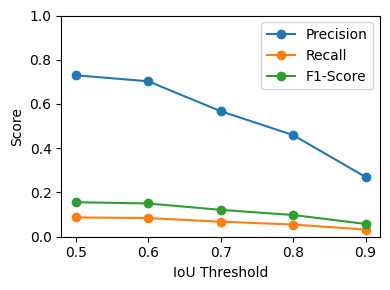

In [ ]:
# =============================================================================
# Performance Visualization
# =============================================================================

# Create figure with compact dimensions suitable for publication
plt.figure(figsize=(4, 3))

# Plot precision scores across IoU thresholds with circular markers
plt.plot(iou_thresholds, precisions, marker='o', label='Precision')
# Plot recall scores across IoU thresholds with circular markers  
plt.plot(iou_thresholds, recalls,    marker='o', label='Recall')
# Plot F1-scores across IoU thresholds with circular markers
plt.plot(iou_thresholds, f1_scores,  marker='o', label='F1-Score')

# Set x-axis label to indicate IoU threshold range
plt.xlabel('IoU Threshold')
# Set y-axis label to indicate metric scale (0-1)
plt.ylabel('Score')

# Set y-axis limits from 0 to 1 for consistent scale across all metrics
plt.ylim(0, 1)  
# Add legend to distinguish between different metrics
plt.legend()
# Apply tight layout to minimize whitespace and improve appearance
plt.tight_layout()
# Save plot as high-resolution PNG for publication quality
plt.savefig('watershed_iou.png', format = 'png', dpi =300)
# Display the plot in the notebook
plt.show()